/Users/tanvibangar/.virtualenvs/r-tensorflow/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Found 3185 images belonging to 3 classes.
Found 1061 images belonging to 3 classes.


🔧 Training model on all quadrants...
Epoch 1/5
100/100 [==============================] - 2329s 23s/step - loss: 0.9900 - accuracy: 0.6948 - val_loss: 0.4285 - val_accuracy: 0.8266
Epoch 2/5
100/100 [==============================] - 8038s 81s/step - loss: 0.4913 - accuracy: 0.7683 - val_loss: 0.4897 - val_accuracy: 0.7842
Epoch 3/5
100/100 [==============================] - 9954s 100s/step - loss: 0.4596 - accuracy: 0.8016 - val_loss: 0.4234 - val_accuracy: 0.8238
Epoch 4/5
100/100 [==============================] - 3106s 31s/step - loss: 0.4374 - accuracy: 0.8082 - val_loss: 0.4117 - val_accuracy: 0.8247
Epoch 5/5
100/100 [==============================] - 3124s 31s/step - loss: 0.4579 - accuracy: 0.7978 - val_loss: 0.4331 - val_accuracy: 0.8040


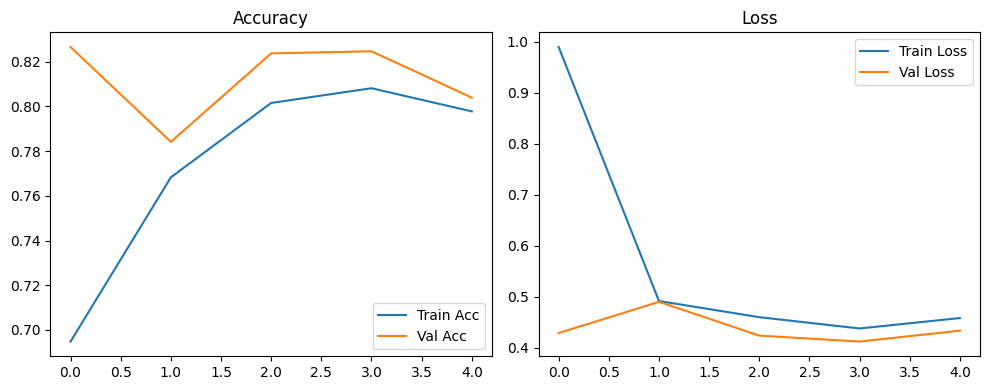


📊 Evaluating on 'uncentered' quadrants...



Testing Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Found 1100 images belonging to 3 classes.

📁 Report for uncentered Q1
              precision    recall  f1-score   support

       Empty       0.95      1.00      0.98       100
   Non-tumor       0.67      0.99      0.80       500
       Tumor       0.99      0.52      0.68       500

    accuracy                           0.77      1100
   macro avg       0.87      0.83      0.82      1100
weighted avg       0.84      0.77      0.76      1100



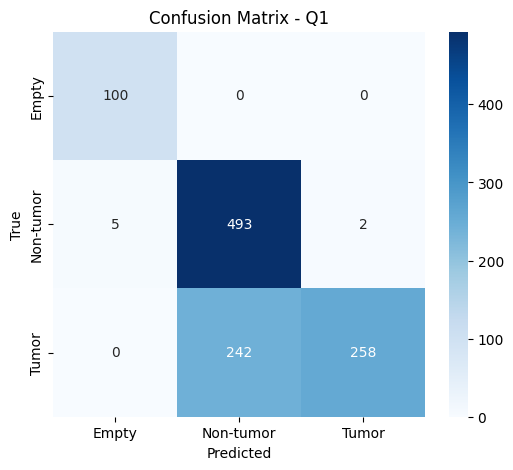

Testing Progress:  25%|██▌       | 1/4 [13:03<39:11, 783.67s/it]

Found 1100 images belonging to 3 classes.

📁 Report for uncentered Q2
              precision    recall  f1-score   support

       Empty       0.74      1.00      0.85       100
   Non-tumor       0.70      0.90      0.79       500
       Tumor       0.96      0.60      0.74       500

    accuracy                           0.78      1100
   macro avg       0.80      0.84      0.79      1100
weighted avg       0.82      0.78      0.77      1100



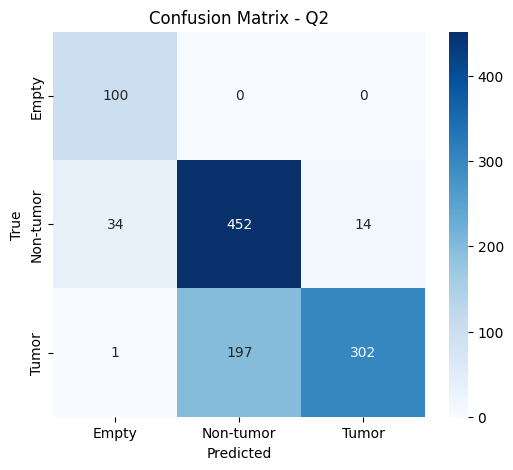

Testing Progress:  50%|█████     | 2/4 [25:58<25:56, 778.25s/it]

Found 1100 images belonging to 3 classes.

📁 Report for uncentered Q3
              precision    recall  f1-score   support

       Empty       0.81      0.89      0.85       100
   Non-tumor       0.73      0.95      0.82       500
       Tumor       0.98      0.66      0.79       500

    accuracy                           0.81      1100
   macro avg       0.84      0.83      0.82      1100
weighted avg       0.85      0.81      0.81      1100



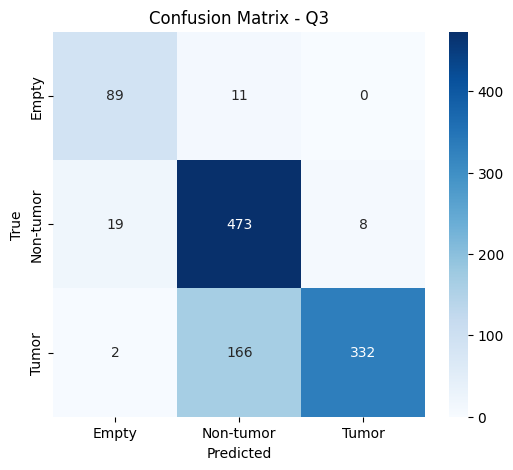

Testing Progress:  75%|███████▌  | 3/4 [39:07<13:03, 783.12s/it]

Found 1100 images belonging to 3 classes.

📁 Report for uncentered Q4
              precision    recall  f1-score   support

       Empty       0.69      1.00      0.82       100
   Non-tumor       0.65      0.91      0.76       500
       Tumor       0.98      0.49      0.65       500

    accuracy                           0.73      1100
   macro avg       0.77      0.80      0.74      1100
weighted avg       0.80      0.73      0.72      1100



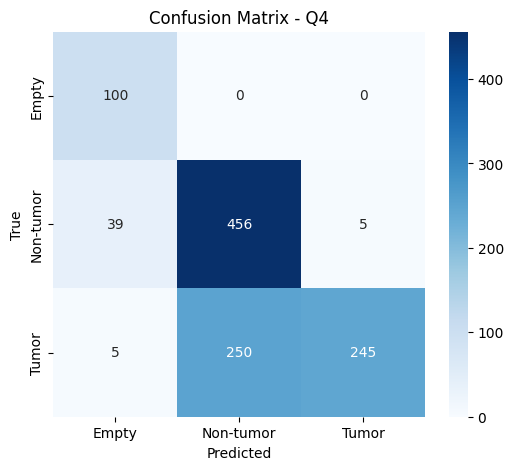

Testing Progress: 100%|██████████| 4/4 [52:07<00:00, 781.82s/it]


In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

# CONFIG
BASE_DIR = "100_stratified4fold_1000per_seed3888 copy"
UNCENTERED_DIR = "uncentered"
TEMP_TRAIN_DIR = "temp_train_all"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
SEED = 42
CLASS_NAMES = ['Empty', 'Non-tumor', 'Tumor']
QUADRANTS = ['Q1', 'Q2', 'Q3', 'Q4']

# UTILITY: Prepare training folder by combining all quadrants
def prepare_full_train_dir():
    if os.path.exists(TEMP_TRAIN_DIR):
        shutil.rmtree(TEMP_TRAIN_DIR)
    os.makedirs(TEMP_TRAIN_DIR)

    for cls in CLASS_NAMES:
        os.makedirs(os.path.join(TEMP_TRAIN_DIR, cls))

    for quad in QUADRANTS:
        quad_path = os.path.join(BASE_DIR, quad)
        for cls in CLASS_NAMES:
            src = os.path.join(quad_path, cls)
            dst = os.path.join(TEMP_TRAIN_DIR, cls)
            for file in os.listdir(src):
                shutil.copy(os.path.join(src, file), os.path.join(dst, file))

# UTILITY: Plot training performance
def plot_training(history):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# UTILITY: Confusion matrix
def show_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# STEP 1: Prepare training data from all 4 quadrants
prepare_full_train_dir()

# STEP 2: Training setup
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_gen = datagen.flow_from_directory(
    TEMP_TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_gen = datagen.flow_from_directory(
    TEMP_TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=SEED
)

# STEP 3: Define and train model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

print("🔧 Training model on all quadrants...")
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)

plot_training(history)

# STEP 4: Test on each uncentered quadrant
print("\n📊 Evaluating on 'uncentered' quadrants...\n")
for i, test_quad in enumerate(tqdm(QUADRANTS, desc="Testing Progress")):
    test_dir = os.path.join(UNCENTERED_DIR, test_quad)

    test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir,
        target_size=IMAGE_SIZE,
        batch_size=1,
        class_mode='categorical',
        shuffle=False
    )

    preds = model.predict(test_gen, verbose=0)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes

    print(f"\n📁 Report for uncentered {test_quad}")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    show_confusion_matrix(y_true, y_pred, f'Confusion Matrix - {test_quad}')

# Cleanup
shutil.rmtree(TEMP_TRAIN_DIR)
